In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import torch.utils.data
# from torchvision import datasets, transforms
import numpy as np
import argparse
from udlp.autoencoder.denoisingAutoencoder import DenoisingAutoencoder
from pacdataset import PacDataset
from matplotlib import pyplot as plt

from torchvision import transforms


%matplotlib inline

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
batch_size = 4
lr = 0.001
epochs = 2

# Set up datasets and data loader

In [3]:
# "/Users/josephmann/Documents/Gheiratmand/sMRI competition/PAC Data/pac2018/"


batch_size = 4
datasets = {x: PacDataset(train=(x=='train'), 
                          root_dir = "/home/paperspace/data/pac2018/") 
#                           root_dir = "/Users/josephmann/Documents/Gheiratmand/sMRI competition/PAC Data/pac2018/") 
            for x in ['val','train']}

train_loader = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size= batch_size, shuffle=True, num_workers=2, )
test_loader = torch.utils.data.DataLoader(
    datasets['val'],
    batch_size= batch_size, shuffle=False, num_workers=2)

# DEA with PAC

In [4]:
in_features = 17545
out_features = 500
dae = DenoisingAutoencoder(in_features, out_features)
dae.fit(train_loader, test_loader, lr=lr, num_epochs=epochs, loss_type="cross-entropy")

=====Denoising Autoencoding layer=======
####Epoch 0: Valid Reconstruct Loss: 12374.130
#Epoch   1: Reconstruct Loss: -198773.604, Valid Reconstruct Loss: -202159.019
#Epoch   2: Reconstruct Loss: -206150.810, Valid Reconstruct Loss: -208052.151


# SDEA with PAC

In [5]:
from udlp.autoencoder.stackedDAE import StackedDAE


In [9]:
# in_features = 784
in_features = 17545
out_features = 500
pretrainepochs = 10 
epochs = 10
z_dim = 50
batch_size = 32

sdae = StackedDAE(input_dim=in_features, z_dim=z_dim, binary=True,
    encodeLayer=[4000,1000,500], decodeLayer=[500,1000,4000], activation="relu", 
    dropout=0)

In [7]:
sdae.pretrain(train_loader, test_loader, lr=lr, batch_size= batch_size, 
    num_epochs=pretrainepochs, corrupt=0, loss_type="mse")
sdae.save_model("model/sdae.pt")

In [10]:
sdae.fit(train_loader, test_loader, lr= lr, 
         num_epochs= epochs, corrupt=0, loss_type="mse") # loss_type was cross-entropy

=====Stacked Denoising Autoencoding layer=======
#Epoch 0: Valid Reconstruct Loss: 21930.352
#Epoch   1: Reconstruct Loss: 9022.087, Valid Reconstruct Loss: 8944.073
#Epoch   2: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   3: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   4: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   5: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   6: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   7: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   8: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch   9: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073
#Epoch  10: Reconstruct Loss: 8961.436, Valid Reconstruct Loss: 8944.073


In [24]:
torch.Tensor([1,2])


 1
 2
[torch.FloatTensor of size 2]

In [39]:
sdae.save_model("model/pre_vade.pt")

In [22]:
sdae.load_model("model/pre_vade.pt")

In [24]:
sdae.fit(train_loader, test_loader, lr= lr, num_epochs= 2, corrupt=0, loss_type="mse")


=====Stacked Denoising Autoencoding layer=======
#Epoch 0: Valid Reconstruct Loss: 203.049
#Epoch   1: Reconstruct Loss: 198.577, Valid Reconstruct Loss: 203.363
#Epoch   2: Reconstruct Loss: 197.957, Valid Reconstruct Loss: 203.613


## Visualize a reconstruction...

inputs shape torch.Size([4, 17545])
min val for image: 1 -0.5532251596450806
4
0 (4, 121, 145)
inputs shape torch.Size([4, 17545])
min val for image: 17 -0.5438387989997864
4
1 (4, 121, 145)
inputs shape torch.Size([4, 17545])
min val for image: 17 -0.5505648851394653
4
2 (4, 121, 145)
inputs shape torch.Size([4, 17545])
min val for image: 17 -0.5552010536193848
4
3 (4, 121, 145)


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


inputs shape torch.Size([4, 17545])
min val for image: 17 -0.551437497138977
4
4 (4, 121, 145)


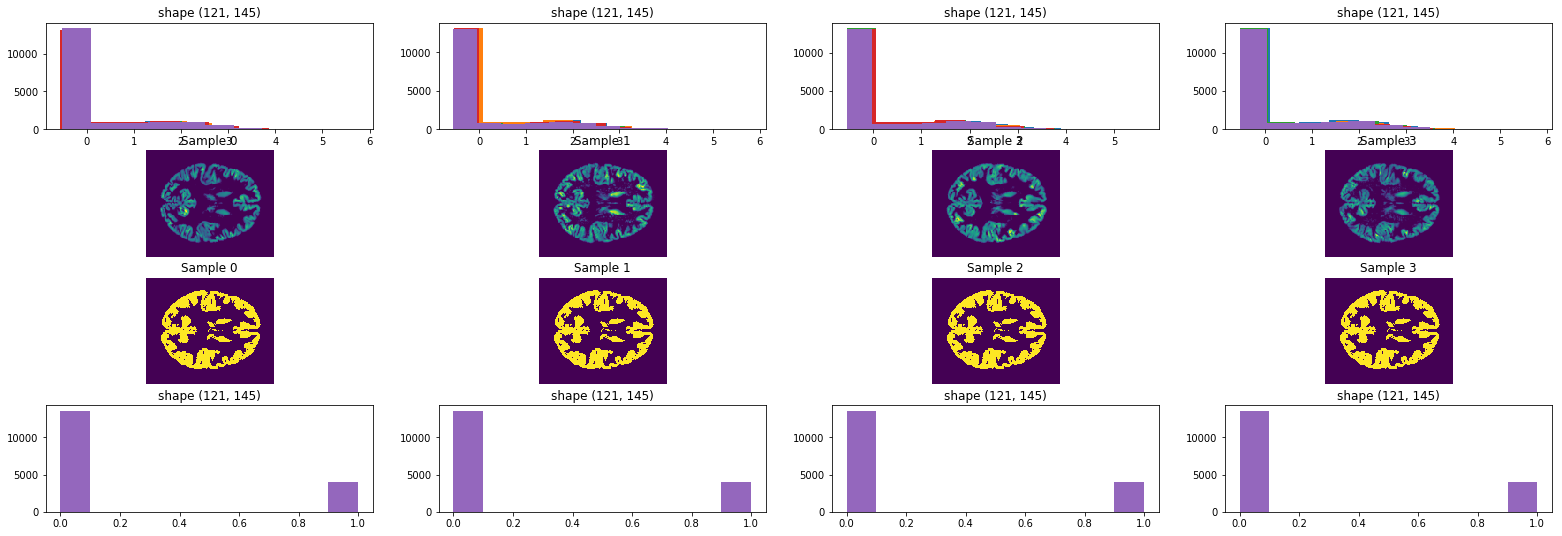

In [8]:
# face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
#                                     root_dir='faces/')
from matplotlib import pyplot as plt
from torch.autograd import Variable
fig = plt.figure(figsize=(12,12))

batch_size= 4
use_cuda = torch.cuda.is_available()
# for i in range(4): #len(datasets[0])):
figure = plt.figure(figsize=(27, 9))
i= 1
for batch_idx, inputs in enumerate(train_loader):    
    if batch_idx > 4: 
        continue
    print("inputs shape", inputs.shape)
#     inputs = datasets['train'][i]
    print('min val for image:', i ,inputs.min())

    inputs = inputs.view(inputs.size(0), -1).float()
    print(len(inputs))
    if use_cuda:
        inputs = inputs.cuda()
    inputs = Variable(inputs)
    z, outputs = sdae.forward(inputs)
#     f_sample = sdae.forward(datasets['train'][i])
    sample = inputs.data.cpu().numpy().reshape(batch_size, 121,145)
    sample_out = outputs.data.cpu().numpy().reshape(batch_size, 121,145)

    print(batch_idx, sample.shape)
    i = 1
    for b_idx in range(batch_size):
        
        ax = plt.subplot(4, 4, i)
        ax.set_title(f'shape {sample[b_idx].shape}')
#         ax.axis('off')
        ax.hist(sample[b_idx].flatten())
        i += 1
        
    for b_idx in range(batch_size):
        
        ax = plt.subplot(4, 4, i)
        ax.set_title(f'Sample {b_idx}')
        ax.axis('off')
        ax.imshow(sample[b_idx])
        i += 1
        
    for b_idx in range(batch_size):
        ax = plt.subplot(4, 4, i)
        ax.set_title(f'Sample {b_idx}')
        ax.axis('off')
        ax.imshow(sample_out[b_idx])
        i += 1
        
    for b_idx in range(batch_size):
        
        ax = plt.subplot(4, 4, i)
        ax.set_title(f'shape {sample[b_idx].shape}')
#         ax.axis('off')
        ax.hist(sample_out[b_idx].flatten())
        i += 1

plt.show()

 

In [18]:
121*145*121


2122945

# Test VaDE with PAC and pre-trained model
just for file format



In [6]:
# "/Users/josephmann/Documents/Gheiratmand/sMRI competition/PAC Data/pac2018/"


batch_size = 4
datasets = {x: PacDataset(train=(x=='train'), 
                          root_dir = "/home/paperspace/data/pac2018/") 
#                           root_dir = "/Users/josephmann/Documents/Gheiratmand/sMRI competition/PAC Data/pac2018/") 
            for x in ['val','train']}

train_loader = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size= batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    datasets['val'],
    batch_size= batch_size, shuffle=False, num_workers=2)

In [3]:
# lets try to extract our latent var and see if we can run gmm on it


In [8]:
from udlp.clustering.vade import VaDE
args_pretrain = 'model/pre_vade.pt'

in_features = 17545
out_features = 500
pretrainepochs = 20 
epochs = 2
z_dim = 50

lr = 0.001

vade = VaDE(input_dim=in_features, z_dim=z_dim, n_centroids=3, binary=True,
        encodeLayer=[4000,1000,500], decodeLayer=[500,1000,4000], debug=True)

if args_pretrain != "":
    print("Loading model from %s..." % args_pretrain)
    vade.load_model(args_pretrain)
print("Initializing through GMM..")
data = vade.initialize_gmm(train_loader)

Loading model from model/pre_vade.pt...
Initializing through GMM..
starting forward loop ***************
z size = torch.Size([4, 50])
outputs size = torch.Size([4, 17545])
mu size = torch.Size([4, 50])
logvar size = torch.Size([4, 50])
z size = torch.Size([4, 50])
outputs size = torch.Size([4, 17545])
mu size = torch.Size([4, 50])
logvar size = torch.Size([4, 50])
ending forward loop ***************
in initialize_gmm: data.shape = (1254, 50)
self.u_p = torch.Size([50, 3])


In [9]:
data.shape

(1254, 50)

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
pca.components_.T.shape

(1254, 2)

## Plot of top 2 components of latent vars $z$

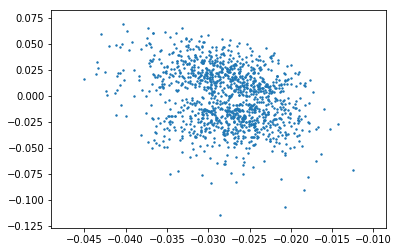

In [31]:
plt.scatter(pca.components_.T[:,0],pca.components_.T[:,1], s=2)

In [14]:
data[:10,:10]

array([[-2.44757801e-01, -9.99676585e-02,  1.92297213e-02,
        -1.34715453e-01,  1.09051995e-01,  1.16301179e-02,
        -8.55872631e-02, -8.93854201e-01, -4.92680371e-02,
        -1.18397033e+00],
       [-2.75488764e-01, -9.33497399e-02,  1.19029442e-02,
        -1.80174381e-01,  1.15835346e-01,  1.07738599e-02,
        -7.80675113e-02, -8.32766116e-01, -5.43530509e-02,
        -1.07866383e+00],
       [ 5.14658540e-03, -2.40911543e-02,  4.10008207e-02,
         1.13658302e-01,  1.71328411e-02, -3.60746458e-02,
        -6.23981655e-03, -6.45328104e-01, -4.61674631e-02,
        -9.95205224e-01],
       [-6.47248402e-02, -7.61250556e-02,  4.56433222e-02,
         7.26275817e-02,  5.68139553e-02, -8.99264961e-03,
        -5.78785092e-02, -8.93122256e-01, -4.24380600e-02,
        -1.30319285e+00],
       [ 1.11523941e-02,  1.44196302e-03,  3.28791663e-02,
         9.78124067e-02,  2.76535749e-03, -4.79733087e-02,
         1.73098668e-02, -5.01570106e-01, -4.85374592e-02,
        -7.

In [37]:
from sklearn.mixture import GaussianMixture
n_centroids = 2
gmm = GaussianMixture(n_components= n_centroids, covariance_type='diag')
gmm.fit(data)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [38]:
gmm.means_.shape

(2, 50)

(array([ 2.,  0.,  2.,  2.,  5.,  4., 62., 16.,  2.,  5.]),
 array([-1.69299858, -1.44535631, -1.19771404, -0.95007176, -0.70242949,
        -0.45478722, -0.20714494,  0.04049733,  0.2881396 ,  0.53578188,
         0.78342415]),
 <a list of 10 Patch objects>)

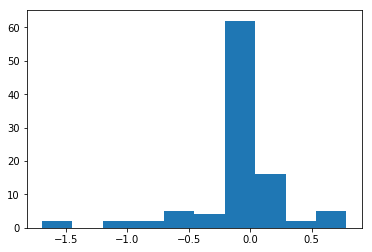

In [39]:
plt.hist(gmm.means_.flatten())

(array([76.,  9., 10.,  0.,  3.,  0.,  0.,  0.,  0.,  2.]),
 array([5.75040104e-06, 6.68499903e-03, 1.33642477e-02, 2.00434963e-02,
        2.67227449e-02, 3.34019935e-02, 4.00812422e-02, 4.67604908e-02,
        5.34397394e-02, 6.01189880e-02, 6.67982367e-02]),
 <a list of 10 Patch objects>)

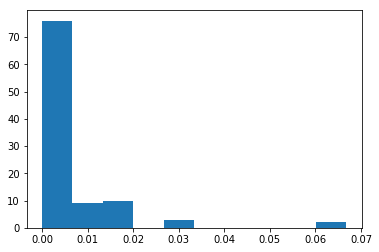

In [40]:
plt.hist(gmm.covariances_.flatten())

In [13]:
gmm.covariances_.min()

3.712797086961739e-06

In [41]:
import seaborn as sns
import pandas as pd

In [ ]:
sns.pairplot(pd.DataFrame(data))

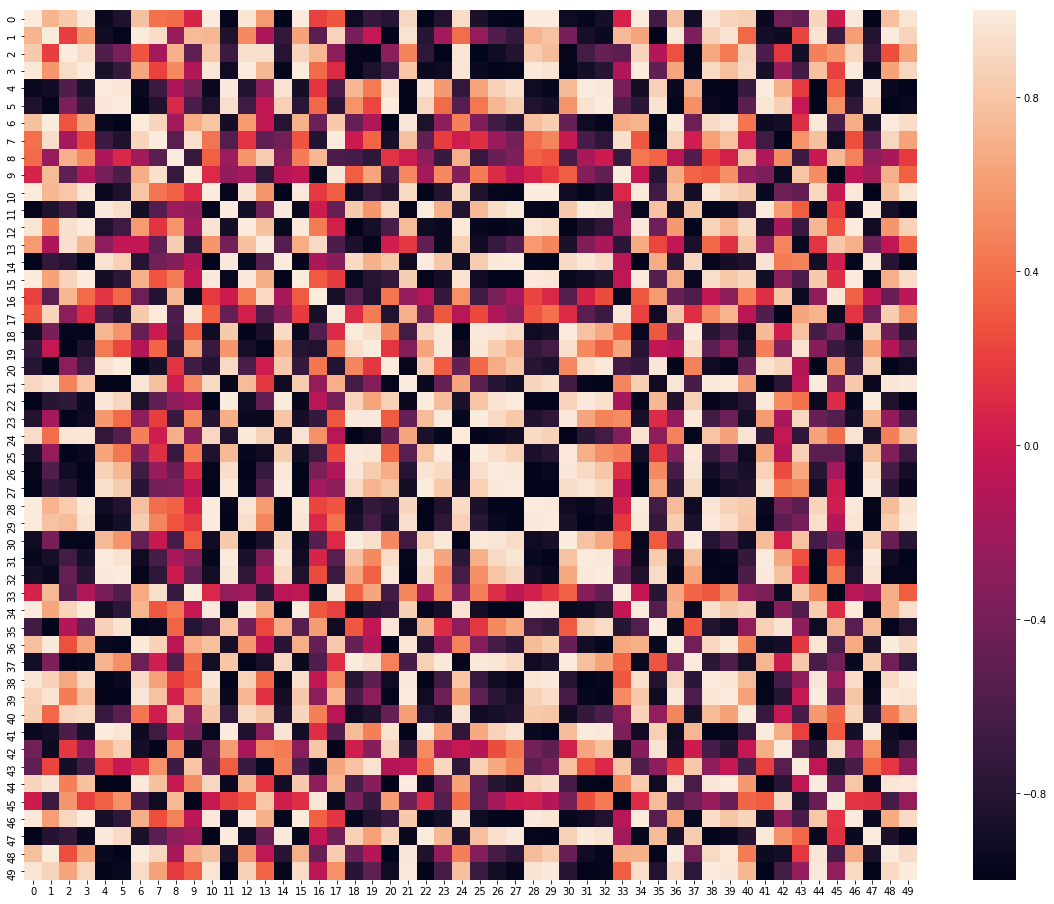

In [49]:
plt.figure(figsize=(20,16))
sns.heatmap(pd.DataFrame(data).corr())

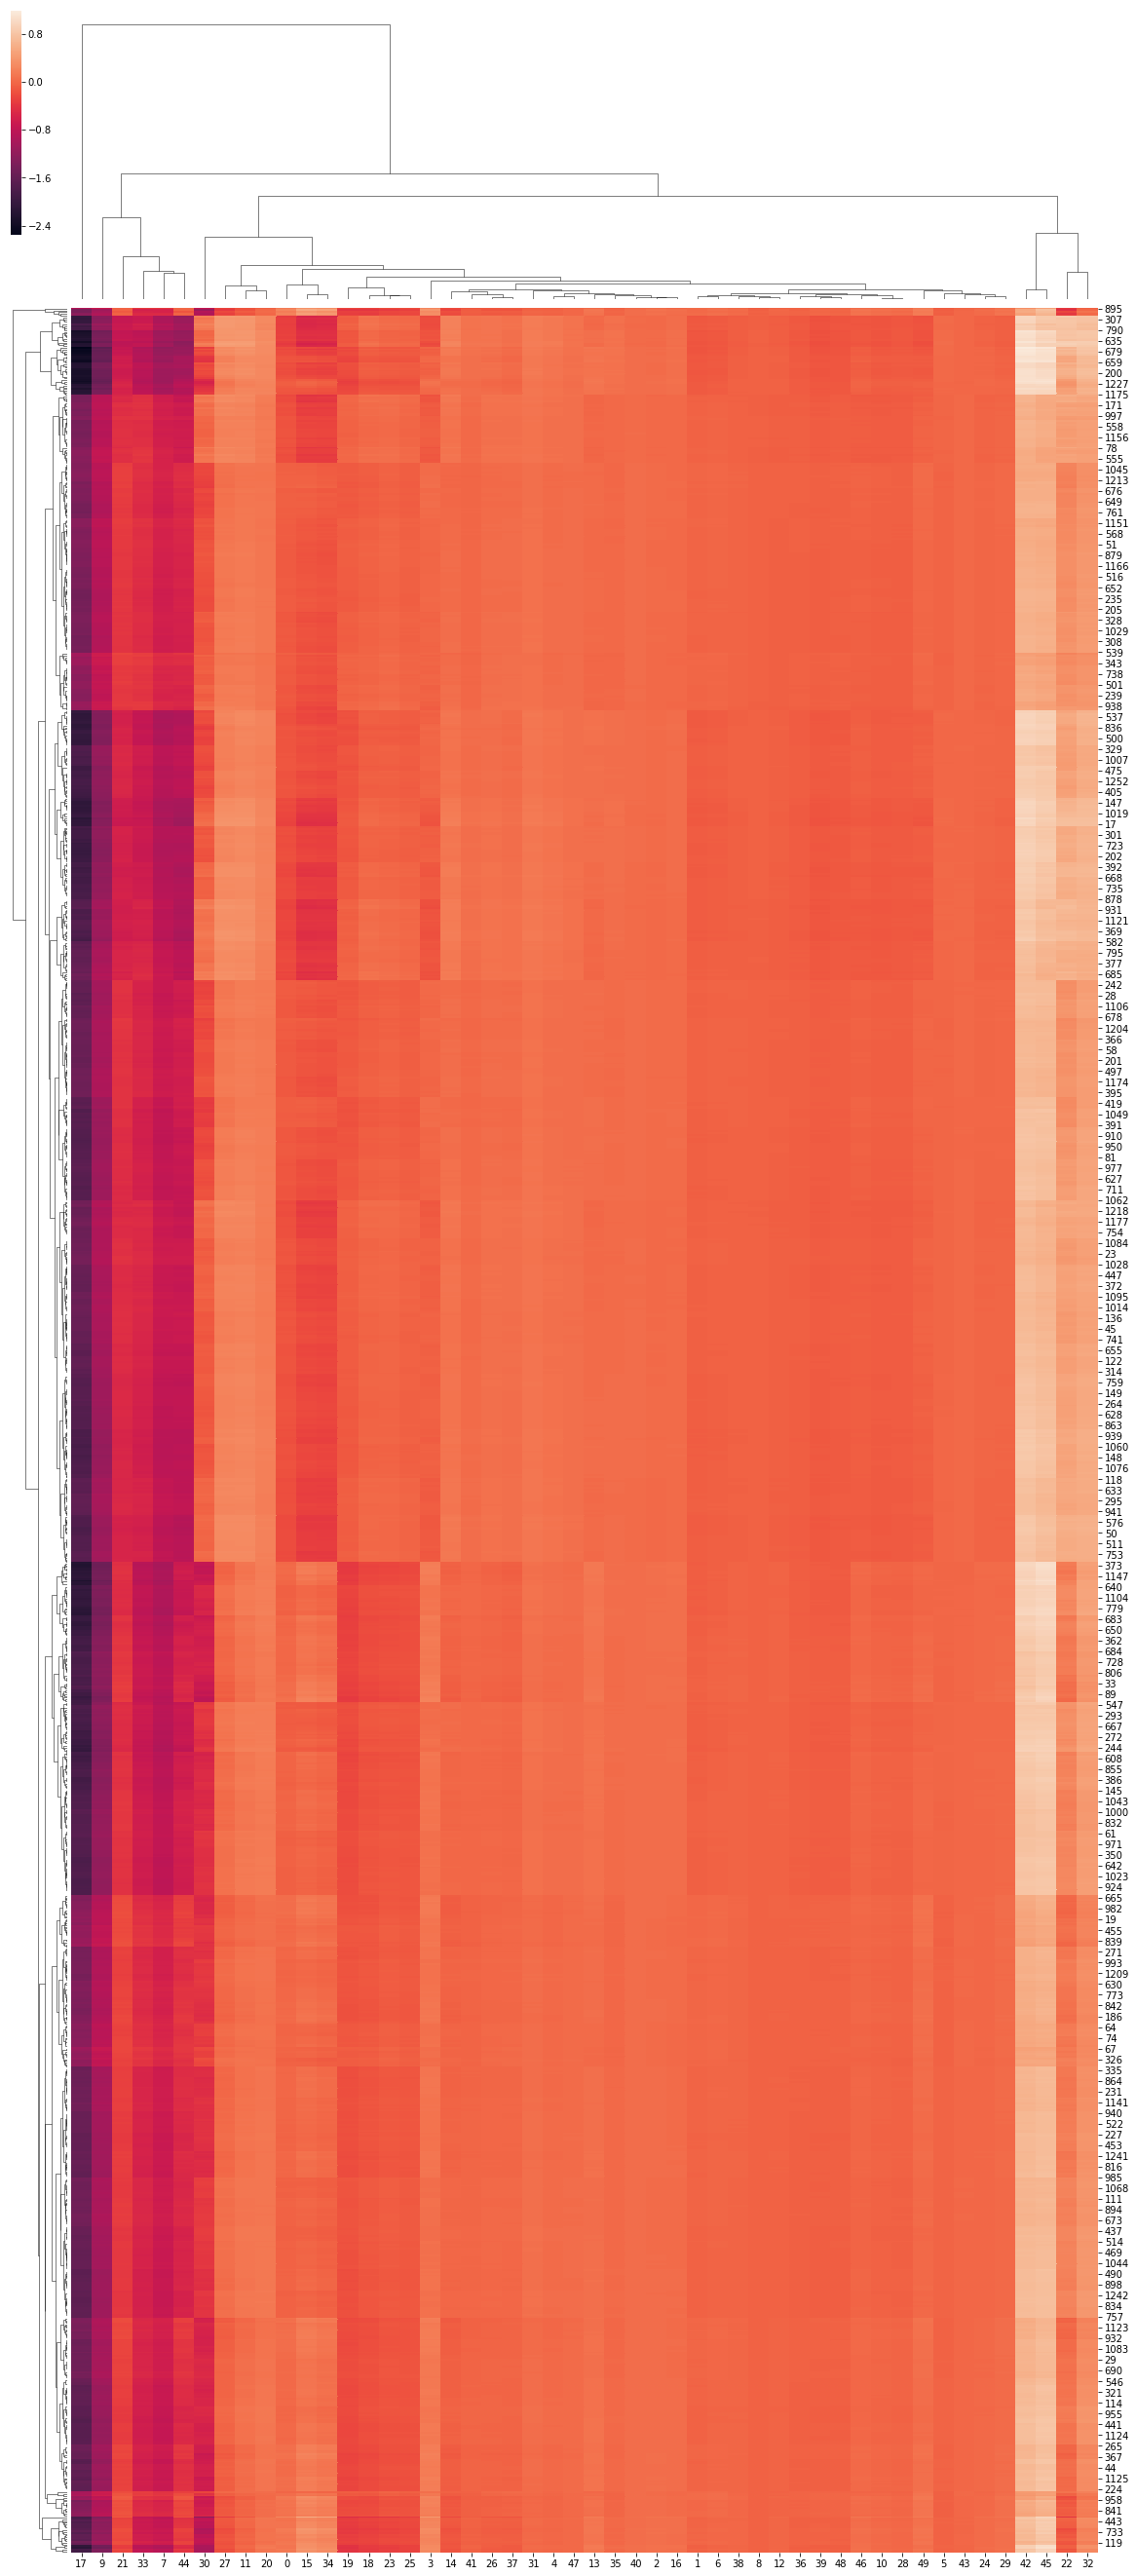

In [54]:
plt.figure(figsize=(28,16))
sns.clustermap(pd.DataFrame(data),figsize=(20,48))

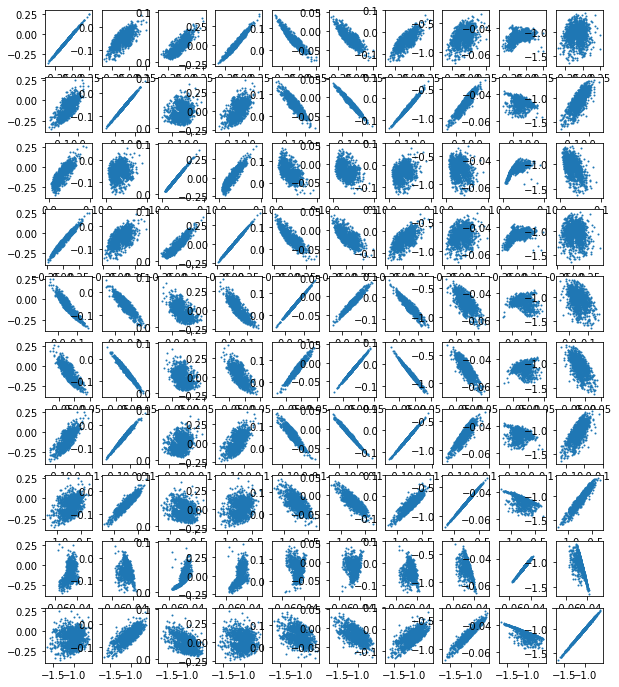

In [27]:
plt.figure(figsize = (10,12))
k = 1
n = 10 
for i,j in [(k,l) for k in range(n) for l in range(n)]:
    ax = plt.subplot(n, n, k)
    ax.scatter(data[:,i],data[:,j], s=1)
    k += 1 

In [41]:
print("starting fit *************")
vade.fit(train_loader, test_loader, lr=lr, 
         batch_size=batch_size, 
         num_epochs=epochs, 
         anneal=True)

starting fit *************
z size : torch.Size([4, 50])
outputs size : torch.Size([4, 17545])
inputs size : torch.Size([4, 17545])
mu size : torch.Size([4, 50])
torch.Size([4, 50, 12])
torch.Size([4, 50, 3])
Variable containing:
 214
[torch.cuda.ByteTensor of size 1 (GPU 0)]

Variable containing:
 2.9006e+00  3.8153e+00  1.1595e+01  1.1709e+01  9.8925e+00  4.9943e+00
-6.8765e-02 -6.8765e-02 -6.0826e-02 -6.0826e-02 -6.0826e-02  3.9235e-02
-1.1297e-01 -7.7344e-03 -8.1594e-02 -4.2009e-02 -3.6366e-02  2.1808e-02
 5.5315e-04  2.5780e-03  4.9721e-04  2.0318e-04  5.9532e-04  6.6559e-05
[torch.cuda.FloatTensor of size 4x6 (GPU 0)]

p_c_z = Variable containing:
 2.5012e+07  6.5773e+23         inf
        inf  1.7360e+17  1.1220e+17
        inf         inf  5.5152e+14
 3.0535e+01         inf  5.7636e+28
[torch.cuda.FloatTensor of size 4x3 (GPU 0)]

log_norm.max() = Variable containing:
 5.3028
[torch.cuda.FloatTensor of size 1 (GPU 0)]

theta_tensor2.abs().max() Variable containing:
 0.3333
[tor

In [23]:
1880 / 214


8.785046728971963

In [30]:
t = torch.Tensor([[1,2,-1],[-3,4,2]])

In [33]:
(t > 0) | (t < 2)



 1  1  1
 1  1  1
[torch.ByteTensor of size 2x3]

In [41]:
vade.save_model("model/vade2k5c5c_1.pt")

In [37]:
vade.load_model("model/vade1.pt")
print("Initializing through GMM..")
batch_size = 32
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

In [59]:
from udlp.clustering.vade import VaDE
args_pretrain = 'model/pre_vade.pt'

vade = VaDE(input_dim=in_features, z_dim=20, n_centroids=50, binary=True,
        encodeLayer=[2000,500,2000], decodeLayer=[2000,500,2000])

lr = 0.0003

if args_pretrain != "":
    print("Loading model from %s..." % args_pretrain)
    vade.load_model(args_pretrain)
print("Initializing through GMM..")
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

Loading model from model/pre_vade.pt...


RuntimeError: While copying the parameter named encoder.0.weight, whose dimensions in the model are torch.Size([2000, 17545]) and whose dimensions in the checkpoint are torch.Size([4000, 17545]).

In [51]:
from udlp.clustering.vade import VaDE
args_pretrain = 'model/pre_vade.pt'

z_dim = 20
n_centroids = 20
vade = VaDE(input_dim=in_features, z_dim=z_dim, n_centroids=n_centroids, binary=True,
        encodeLayer=[2000,500,2000], decodeLayer=[2000,500,2000])

# if args_pretrain != "":
#     print("Loading model from %s..." % args_pretrain)
#     vade.load_model(args_pretrain)
print("Initializing through GMM..")
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

Initializing through GMM..
#Epoch -1: Valid Loss: nan
#Epoch   0: lr: 0.00100, Train Loss: 6242.55512, Valid Loss: 3307.95430, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: 3317.17495, Valid Loss: 3339.55438, acc: 0.00000
#Epoch   2: lr: 0.00100, Train Loss: 3308.81975, Valid Loss: 3289.09791, acc: 0.00000
#Epoch   3: lr: 0.00100, Train Loss: 3303.23821, Valid Loss: 3262.72100, acc: 0.00000
#Epoch   4: lr: 0.00100, Train Loss: 3311.81923, Valid Loss: 3269.18336, acc: 0.00000
#Epoch   5: lr: 0.00100, Train Loss: 3293.82434, Valid Loss: 3321.69122, acc: 0.00000
#Epoch   6: lr: 0.00100, Train Loss: 3287.29481, Valid Loss: 3243.17547, acc: 0.00000
#Epoch   7: lr: 0.00100, Train Loss: 3272.09096, Valid Loss: 3257.97516, acc: 0.00000
#Epoch   8: lr: 0.00100, Train Loss: 3269.02134, Valid Loss: 3237.02857, acc: 0.00000
#Epoch   9: lr: 0.00100, Train Loss: 3261.04076, Valid Loss: 3233.40067, acc: 0.00000
#Epoch  10: lr: 0.00090, Train Loss: 3260.28980, Valid Loss: 3232.83958, acc: 0.00000


In [52]:
vade.save_model("model/vade2k5c2k_2020_1.pt")

In [54]:
vade.load_model("model/vade2k5c2k_2020_1.pt")
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

#Epoch -1: Valid Loss: nan
#Epoch   0: lr: 0.00100, Train Loss: 3311.62904, Valid Loss: 3223.40162, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: nan, Valid Loss: nan, acc: 0.00000


Process Process-1772:
  File "/home/paperspace/github/UnsupervisedDeepLearning-Pytorch/test/pacdataset.py", line 15, in _jload
    img_data = img.get_data()
Process Process-1771:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = c

KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/nibabel/dataobj_images.py", line 202, in get_data
    data = np.asanyarray(self._dataobj)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/nibabel/volumeutils.py", line 965, in apply_read_scaling
    arr = arr * slope
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/numeric.py", line 544, in asanyarray
    return array(a, dtype, copy=False, order=order, subok=True)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/core/memmap.py", line 319, in __array_wrap__
    def __array_wrap__(self, arr, context=None):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/nibabel/arrayproxy.py", line 291, in __array__
    return apply_read_scaling(raw_data, self._slope, self._inter)
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/nibabel/volumeutils.py", line 965, in 

In [44]:
vade.save_model("model/vade2k5c2k_1.pt")

In [45]:
vade.load_model("model/vade2k5c2k_1.pt")
print("Initializing through GMM..")
lr = 0.001
batch_size = 32
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

Initializing through GMM..
#Epoch -1: Valid Loss: 6526.86497
#Epoch   0: lr: 0.00100, Train Loss: 3262.76987, Valid Loss: 3232.34285, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: 3242.06520, Valid Loss: 3211.50148, acc: 0.00000
#Epoch   2: lr: 0.00100, Train Loss: 3242.81475, Valid Loss: 3210.97557, acc: 0.00000
#Epoch   3: lr: 0.00100, Train Loss: 3236.35666, Valid Loss: 3204.28867, acc: 0.00000
#Epoch   4: lr: 0.00100, Train Loss: 3235.02464, Valid Loss: 3200.39091, acc: 0.00000
#Epoch   5: lr: 0.00100, Train Loss: 3247.62324, Valid Loss: 3212.14897, acc: 0.00000
#Epoch   6: lr: 0.00100, Train Loss: 3234.69476, Valid Loss: 3191.59323, acc: 0.00000
#Epoch   7: lr: 0.00100, Train Loss: 3224.14547, Valid Loss: 3188.05998, acc: 0.00000
#Epoch   8: lr: 0.00100, Train Loss: 3223.49146, Valid Loss: 3187.75288, acc: 0.00000
#Epoch   9: lr: 0.00100, Train Loss: 3220.72840, Valid Loss: 3191.08219, acc: 0.00000
#Epoch  10: lr: 0.00090, Train Loss: 3217.33778, Valid Loss: 3184.41324, acc: 0

In [46]:
vade.save_model("model/vade2k5c2k_2.pt")

In [48]:
vade.load_model("model/vade2k5c2k_2.pt")
print("Initializing through GMM..")
lr = 0.001
batch_size = 32
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

Initializing through GMM..
#Epoch -1: Valid Loss: 8679.95242
#Epoch   0: lr: 0.00100, Train Loss: 3233.41579, Valid Loss: 3186.49018, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: 3209.28563, Valid Loss: 3183.59263, acc: 0.00000
#Epoch   2: lr: 0.00100, Train Loss: 3211.07545, Valid Loss: 3183.09875, acc: 0.00000
#Epoch   3: lr: 0.00100, Train Loss: 3211.02946, Valid Loss: 3182.68724, acc: 0.00000
#Epoch   4: lr: 0.00100, Train Loss: 3211.01418, Valid Loss: 3182.51615, acc: 0.00000
#Epoch   5: lr: 0.00100, Train Loss: 3209.16660, Valid Loss: 3183.76033, acc: 0.00000
#Epoch   6: lr: 0.00100, Train Loss: 3208.18500, Valid Loss: 3181.53952, acc: 0.00000
#Epoch   7: lr: 0.00100, Train Loss: 3210.69156, Valid Loss: 3182.22657, acc: 0.00000
#Epoch   8: lr: 0.00100, Train Loss: 3216.56231, Valid Loss: 3192.80368, acc: 0.00000
#Epoch   9: lr: 0.00100, Train Loss: 3228.06418, Valid Loss: 3204.26479, acc: 0.00000
#Epoch  10: lr: 0.00090, Train Loss: 3213.43192, Valid Loss: 3181.38049, acc: 0

In [49]:
vade.save_model("model/vade2k5c2k_3.pt")

In [50]:
vade.load_model("model/vade2k5c2k_3.pt")
print("Initializing through GMM..")
lr = 0.001
batch_size = 32
vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

Initializing through GMM..
#Epoch -1: Valid Loss: 13186.21874
#Epoch   0: lr: 0.00100, Train Loss: 3230.66995, Valid Loss: 3191.42460, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: 3198.93020, Valid Loss: 3182.39906, acc: 0.00000
#Epoch   2: lr: 0.00100, Train Loss: 3200.67083, Valid Loss: 3181.66593, acc: 0.00000
#Epoch   3: lr: 0.00100, Train Loss: 3199.40258, Valid Loss: 3183.60423, acc: 0.00000
#Epoch   4: lr: 0.00100, Train Loss: 3195.83137, Valid Loss: 3179.73581, acc: 0.00000
#Epoch   5: lr: 0.00100, Train Loss: 3197.30092, Valid Loss: 3181.60865, acc: 0.00000
#Epoch   6: lr: 0.00100, Train Loss: 3194.53059, Valid Loss: 3180.47269, acc: 0.00000
#Epoch   7: lr: 0.00100, Train Loss: 3202.62261, Valid Loss: 3182.16113, acc: 0.00000
#Epoch   8: lr: 0.00100, Train Loss: 3194.71276, Valid Loss: 3183.98300, acc: 0.00000
#Epoch   9: lr: 0.00100, Train Loss: 3197.05575, Valid Loss: 3185.75998, acc: 0.00000
#Epoch  10: lr: 0.00090, Train Loss: 3194.80184, Valid Loss: 3179.34724, acc: 

> I don't know the number of centroids does...

In [47]:
vade.load_model("model/vade2k5c2k_1.pt")
print("Initializing through GMM..")
lr = 0.001
batch_size = 32
# we do NOT want to initialize_gmm each time, oh wait, yes we do.
# vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

Initializing through GMM..
#Epoch -1: Valid Loss: 3219.21289
#Epoch   0: lr: 0.00100, Train Loss: nan, Valid Loss: nan, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: nan, Valid Loss: nan, acc: 0.00000
#Epoch   2: lr: 0.00100, Train Loss: nan, Valid Loss: nan, acc: 0.00000
#Epoch   3: lr: 0.00100, Train Loss: nan, Valid Loss: nan, acc: 0.00000
#Epoch   4: lr: 0.00100, Train Loss: nan, Valid Loss: nan, acc: 0.00000


Process Process-1496:
Process Process-1495:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/paperspace/anaconda3/envs/fa

KeyboardInterrupt: 

In [32]:
# batch_size = 8
# vade.load_model("model/vade1.pt")
# print("Initializing through GMM..")
# vade.initialize_gmm(train_loader)
vade.fit(train_loader, test_loader, lr=lr, batch_size=batch_size, num_epochs=epochs, anneal=True)

#Epoch -1: Valid Loss: 3208.37063
#Epoch   0: lr: 0.00100, Train Loss: 3107.86518, Valid Loss: 3172.76114, acc: 0.00000
#Epoch   1: lr: 0.00100, Train Loss: 3110.91332, Valid Loss: 3176.45886, acc: 0.00000
#Epoch   2: lr: 0.00100, Train Loss: 3110.19600, Valid Loss: 3178.79659, acc: 0.00000
#Epoch   3: lr: 0.00100, Train Loss: 3104.94653, Valid Loss: 3183.62467, acc: 0.00000
#Epoch   4: lr: 0.00100, Train Loss: 3118.62083, Valid Loss: 3178.66328, acc: 0.00000
#Epoch   5: lr: 0.00100, Train Loss: 3114.10822, Valid Loss: 3199.02968, acc: 0.00000
#Epoch   6: lr: 0.00100, Train Loss: 3120.37661, Valid Loss: 3173.95579, acc: 0.00000
#Epoch   7: lr: 0.00100, Train Loss: 3107.35450, Valid Loss: 3185.31540, acc: 0.00000
#Epoch   8: lr: 0.00100, Train Loss: 3095.57662, Valid Loss: 3168.91423, acc: 0.00000
#Epoch   9: lr: 0.00100, Train Loss: 3088.22531, Valid Loss: 3190.91982, acc: 0.00000
#Epoch  10: lr: 0.00090, Train Loss: 3084.56503, Valid Loss: 3168.53700, acc: 0.00000
#Epoch  11: lr: 0.00